### [Checkout the Medium Article here!](https://medium.com/towards-artificial-intelligence/fine-tune-llama3-1-8b-in-2-mins-with-only-12-training-samples-b35b548492a3)

In [ ]:
# install/import unsloth & other important packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install torch==2.3.1 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install xformers --no-cache-dir
!pip install --no-deps trl peft accelerate bitsandbytes triton

from unsloth import FastLanguageModel
from transformers import TrainingArguments
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TextStreamer
import torch

# download the 4-bit model
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_rvboez0/unsloth_34b630b19451411e8a50a2db01081ea8
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_rvboez0/unsloth_34b630b19451411e8a50a2db01081ea8
  Resolved https://github.com/unslothai/unsloth.git to commit d91d40a7b6b556f2d1fdd3e1e430f7a76a799627
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
# load the dataset splits
train_dataset = load_dataset("krnk97/summary_dataset", split = "train")
eval_dataset = load_dataset("krnk97/summary_dataset", split = "validation")

# format the text columns using the Alpaca format
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n

### Instruction:\n
{}\n\n

### Input:\n
{}\n
{}\n\n

### Response:\n
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples["context"]
    outputs      = examples["response"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, EOS_TOKEN, output)
        texts.append(text)
    return { "text" : texts, }

# map the formatting function on train and eval sets
train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,                                 # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj",],
    lora_alpha = 16,
    lora_dropout = 0,                       # Supports any, but = 0 is optimized
    bias = "none",                          # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,                      # We support rank stabilized LoRA
    loftq_config = None,                    # And LoftQ
)

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 0 MLP layers.


In [ ]:
model.print_trainable_parameters()

trainable params: 65,011,712 || all params: 8,095,272,960 || trainable%: 0.8031


In [ ]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

callback = CustomCallback()

In [ ]:
from transformers import TrainingArguments, Trainer
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
    per_device_train_batch_size=2,        # how many batches to train at a time
    gradient_accumulation_steps=4,        # total steps will be divided by this
    warmup_steps=2,                       # steps to go from 0 to specified lr
    num_train_epochs=4,                   # no of samples in each batch * this would be total steps
    learning_rate=2e-4,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    evaluation_strategy="steps",          # Evaluate during training
    eval_steps=1,                         # Evaluate every 1 step
    save_strategy="steps",
    save_steps=10,                        # save model state every 10 steps
    load_best_model_at_end=True,          # Load the best model when finished training
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,          # pass in the training split
    eval_dataset=eval_dataset,            # pass in the eval split
    args=training_args,
    dataset_text_field = "text",
    callbacks=[callback]                  # our custom callback
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [ ]:
# check GPU memory before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
7.854 GB of memory reserved.


In [ ]:
# start training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 12 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 4
 "-____-"     Number of trainable parameters = 65,011,712


Step,Training Loss,Validation Loss
1,1.321800,1.354793
2,1.262100,1.093137
3,1.008100,0.862941
4,0.687200,0.736281


In [ ]:
# check GPU memory after training
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

62.0225 seconds used for training.
1.03 minutes used for training.
Peak reserved memory = 7.854 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 53.255 %.
Peak reserved memory for training % of max memory = 0.0 %.


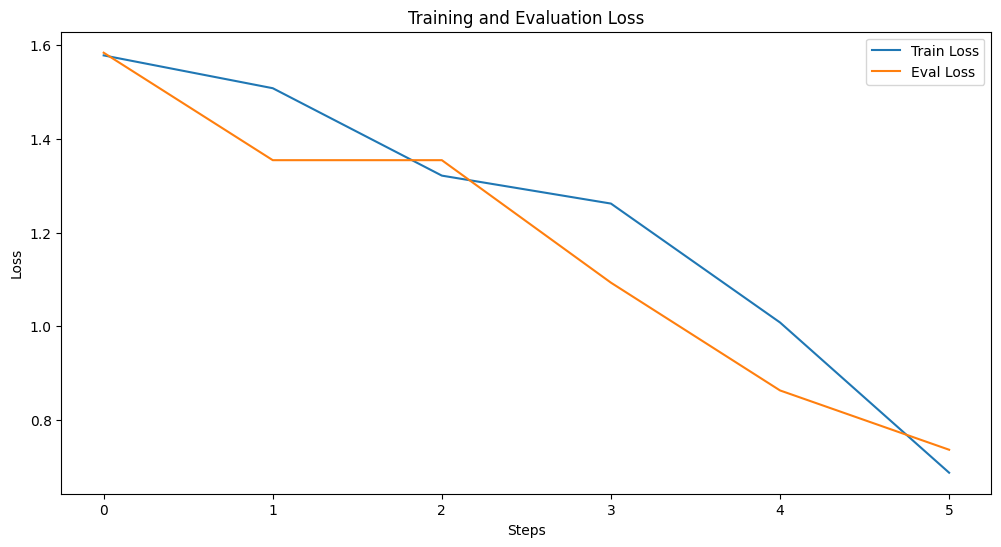

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss for train & eval sets
plt.figure(figsize=(12, 6))
plt.plot(callback.train_losses, label='Train Loss')
plt.plot(callback.eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Summarize the given text about reinforcement learning", # instruction
        "The Markov decision process (MDP) is an effective mathematical tool for modeling sequen-tial decision-making problems in stochastic environments (Derman, 1970; Puterman, 1994).Solving  an  MDP problem  entails  finding  an  optimal  policy  that  maximizes  a  cumulativereward according to a given criterion.  However, due to reasons including non-stationarityof the environment, modeling error, exogenous perturbation, partial observability, and ad-versarial attacks, a model mismatch exists between the assumed MDP model and the un-derlying environment and can result in solution policies with poor performance.  To solvethis  issue,  a  framework  of  robust  MDPs,  e.g.,  (Bagnell  et  al.,  2001;  Nilim  &  El  Ghaoui,2004;  Iyengar,  2005),  has  been  proposed.   Rather  than  adopting  a  fixed  MDP  model,  inrobust MDP, one seeks to optimize the worst-case performance over an uncertainty set ofpossible MDP models.  The solution provides performance guarantees for all MDP modelsin the uncertainty set, and is thus robust to the model mismatch", # input
        EOS_TOKEN,
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n\n\n### Instruction:\n\nSummarize the given text about reinforcement learning\n\n\n\n### Input:\n\nThe Markov decision process (MDP) is an effective mathematical tool for modeling sequen-tial decision-making problems in stochastic environments (Derman, 1970; Puterman, 1994).Solving  an  MDP problem  entails  finding  an  optimal  policy  that  maximizes  a  cumulativereward according to a given criterion.  However, due to reasons including non-stationarityof the environment, modeling error, exogenous perturbation, partial observability, and ad-versarial attacks, a model mismatch exists between the assumed MDP model and the un-derlying environment and can result in solution policies with poor performance.  To solvethis  issue,  a  framework  of  robust  MDPs,  e.g.,  (Bagnell  et  al.,  2001;  Nilim  &  El  Gh

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Summarize the given text on computer vision", # instruction
        """
        A CNN helps a machine learning or deep learning model “look” by breaking images down into pixels that are given tags or labels. It uses the labels to perform convolutions (a mathematical operation on two functions to produce a third function) and makes predictions about what it is “seeing.” The neural network runs convolutions and checks the accuracy of its predictions in a series of iterations until the predictions start to come true. It is then recognizing or seeing images in a way similar to humans.
        Much like a human making out an image at a distance, a CNN first discerns hard edges and simple shapes, then fills in information as it runs iterations of its predictions. A CNN is used to understand single images. A recurrent neural network (RNN) is used in a similar way for video applications to help computers understand how pictures in a series of frames are related to one another.""",
        EOS_TOKEN,
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n\n\n### Instruction:\n\nSummarize the given text on computer vision\n\n\n\n### Input:\n\n\n        A CNN helps a machine learning or deep learning model “look” by breaking images down into pixels that are given tags or labels. It uses the labels to perform convolutions (a mathematical operation on two functions to produce a third function) and makes predictions about what it is “seeing.” The neural network runs convolutions and checks the accuracy of its predictions in a series of iterations until the predictions start to come true. It is then recognizing or seeing images in a way similar to humans.\n        Much like a human making out an image at a distance, a CNN first discerns hard edges and simple shapes, then fills in information as it runs iterations of its predictions. A CNN is used to understand sing